<a href="https://colab.research.google.com/github/kazzand/goznak/blob/main/goznakclf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from tqdm import tqdm
import librosa.feature
from PIL import Image
import os
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from IPython.display import clear_output
from sklearn.metrics import roc_auc_score

In [3]:
custom_model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), bias=True),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=5, stride=2),
    nn.Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), bias=True),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=5, stride=3),
    # nn.Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), bias=True),
    # nn.LeakyReLU(),
    # nn.MaxPool2d(kernel_size=3, stride=1),
    nn.Flatten(),
    nn.Linear(in_features=192, out_features=1, bias=True),
    nn.Sigmoid()
)

In [4]:
def spec2image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

In [5]:
class CLFData(torch.utils.data.Dataset):
    def __init__(self, path_data):
        self.path_data = path_data
        self.class1 = os.listdir(self.path_data + 'noisy')
        self.class1.sort()
        self.class2 = os.listdir(self.path_data + 'clear')
        self.class2.sort()
        self.labels0 = np.zeros(len(self.class1))
        self.labels1 = np.ones(len(self.class2))
        self.all_paths_class1 = np.array([self.path_data + 'noisy/' + name for name in self.class1])
        self.all_paths_class2 = np.array([self.path_data + 'clear/' + name for name in self.class2])
        self.all_paths = np.hstack((self.all_paths_class1,self.all_paths_class2))
        self.labels = np.hstack((self.labels0, self.labels1))
    def __len__(self):
        return len(self.all_paths)
    def __getitem__(self, idx):
        image = spec2image(np.load(self.all_paths[idx]).T)
        if image.shape[1] <= 200:
            image_crop = np.zeros((80,200))
            image_crop[:image.shape[0],:image.shape[1]] = image
        else:
            rand_coord = np.random.randint(0, image.shape[1]-200)
            image_crop = image[:, rand_coord:rand_coord+200]
        image_crop = torch.FloatTensor(image_crop)
        image_crop = image_crop.unsqueeze(0)
        image_crop.requires_grad_(True)
        return image_crop, torch.FloatTensor([self.labels[idx]])

In [6]:
x = torch.ones((30, 1, 80, 200))
print(custom_model)
custom_model(x).shape

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=192, out_features=1, bias=True)
  (8): Sigmoid()
)


torch.Size([30, 1])

In [7]:
train_data = CLFData('/content/gdrive/My Drive/train/')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
val_data = CLFData('/content/gdrive/My Drive/validate/')
val_loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data), shuffle=True)

Epoch:  2


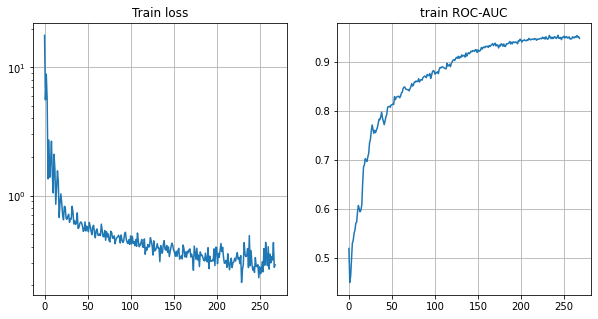

 86%|████████▌ | 81/94 [58:29<08:39, 39.98s/it]

In [ ]:
model = custom_model
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 100
train_loss = []
roc = []

model = model.cuda()

for epoch in range(num_epochs):
    for X_batch, y_batch in tqdm(train_loader):
        clear_output(True)
        X_batch = X_batch.cuda()
        y_batch = y_batch.cuda()

        optimizer.zero_grad()

        predict = model(X_batch)

        loss = nn.BCELoss()(predict,y_batch)
        loss.backward()    

        optimizer.step()

        error = loss.item()
        train_loss.append(error)

        with torch.no_grad():
            for x, y in val_loader:
                x = x.cuda()
                y = y.cuda()
                val_predict = model(x)
    
        
        print('Epoch: ', epoch)
        roc.append(roc_auc_score(y.detach().cpu().numpy(), val_predict.detach().cpu().numpy().ravel()))
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        plt.semilogy(train_loss)
        plt.title('Train loss')
        plt.grid()
        plt.subplot(122)
        plt.plot(roc)
        plt.title('val ROC-AUC')
        plt.grid()
        plt.show()
